# DeepDream

## 1. 数据预处理

In [2]:
import os
import shutil
import torch
import h5py
import numpy as np
import PIL.Image as Image
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision import models
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
from scipy.ndimage.filters import gaussian_filter1d

use_cuda = torch.cuda.is_available()                    # gpu可用
device = torch.device('cuda' if use_cuda else 'cpu')    # 优先使用gpu

D:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess(img, size=224):                                   # 图像预处理
    transform = transforms.Compose([
        transforms.Resize((size,size)),                          # 宽和高都进行resize
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN.tolist(), std=STD.tolist()),
        transforms.Lambda(lambda x:x[None])                      # 增加一个维度变为 (1,C,H,W)
    ])
    return transform(img)
def deprocess(img, should_rescale=False):                                 # 图像还原
    transform = transforms.Compose([
        transforms.Lambda(lambda x: x[0]),                               # 去掉第一维 (C,H,W)
        transforms.Normalize(mean=[0, 0, 0], std=(1.0 / STD).tolist()),  # 乘标准差
        transforms.Normalize(mean=(-MEAN).tolist(), std=[1, 1, 1]),      # 加均值还原数据
        transforms.Lambda(rescale) if should_rescale else transforms.Lambda(lambda x: x), 
        transforms.ToPILImage()                                # 转换为numpy array， (H,W,C)
    ])
    return transform(img)

def rescale(x):                                                # 将范围缩放到[0,1]之间
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()                            # 转换为numpy数组 (N,C,H,W)
    X_np = gaussian_filter1d(X_np, sigma, axis=2)             # 对H与W分别进行高斯滤波
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))                    # 将滤波后的值赋值给X
    return 

In [4]:
# 定义图像抖动函数
def jitter(X, ow, oh):
    X_numpy = X.numpy()                     # 转换为numpy数据
    X_roll = np.roll(X_numpy, ow, -1)       # (N,C,H,W)最后一个维度进行抖动
    X_roll = np.roll(X_roll,  oh, -2)       # (N,C,H,W)倒数第二个维度进行抖动
    X_tensor = torch.from_numpy(X_roll)     # 转换为tensor
    return X_tensor 
def show_tensor(tensor):                    # 显示tensor的图像
    tensor_show = deprocess(tensor)
    plt.axis('off')
    tensor_show = tensor_show.resize((1887, 1059))
    plt.imshow(tensor_show)
    plt.show()

(1024, 640)
torch.Size([1, 3, 224, 224])


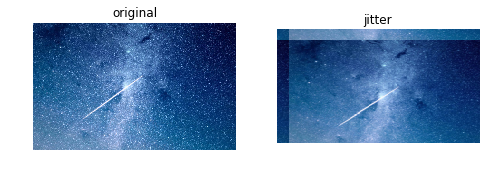

In [5]:
img_path = os.path.join('./image/universe.jpg') # 
max_jitter = 32
fig = plt.figure(figsize=(8,6))
with Image.open(img_path, 'r') as img:
    print(img.size)
    fig.add_subplot(1,2,1)
    plt.title('original')
    plt.axis('off')
    plt.imshow(img)
    img_tensor = preprocess(img)
    print(img_tensor.shape)
    ow, oh = np.random.randint(-max_jitter, max_jitter + 1, 2)
    img_jit = jitter(img_tensor, oh, ow)
#     img_jit = deprocess(img_jit)
    fig.add_subplot(122)
    plt.title('jitter')
    plt.axis('off')
    show_tensor(img_jit)

## 2. 定义模型提取特定的层

In [6]:
# 为了提取模型的特定层这里在预训练模型基础上定义新网络
class myNet(nn.Module):
    def __init__(self, end_layer):
        """
        end_layer: 1~4
        """
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:end_layer-6])   # 提取self.layer3的输出
        for params in self.features.parameters():
            params.requires_grad = False
    def forward(self, x):
        feature_map = self.features(x)
        return feature_map

In [22]:
mynet = myNet(3)
test_in = torch.randn(1,3,224,224)
test_out = mynet(test_in)
print(test_out.shape)

torch.Size([1, 256, 14, 14])


## 3.定义损失函数
损失函数使网络结束层输出的特征向量的L2范数最大化，然后计算梯度，进行反向传播，使用梯度上升来更新图像，
得到最终的deepdream图

L2损失函数：
$$\|x\|_2^2=x_1^2+x_2^2+x_3^2+\dots+x_n^2$$
梯度：
$$\frac{\partial\|x\|_2^2}{\partial p_j}=2\sum_{i=1}^nx_i\frac{\partial x_i}{\partial p_j}$$
使用`act_value.backward(act_value.data)`来计算上述公式

In [38]:
# 定义损失函数
def l2_loss(feature_map, target=None):                   # 直接将tensor的数据返回
    return feature_map.data
def image_read(data_path):
    with Image.open(data_path, 'r') as img:
#         print(img.size)
        img_tensor = preprocess(img)
#         print(img_tensor.shape)
        return img_tensor
out = image_read(img_path)
print(out.shape)

torch.Size([1, 3, 224, 224])


## 4. 训练模型

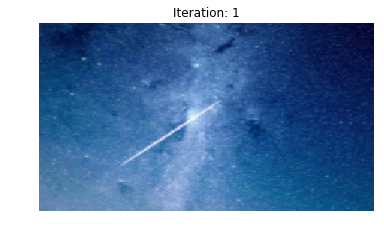

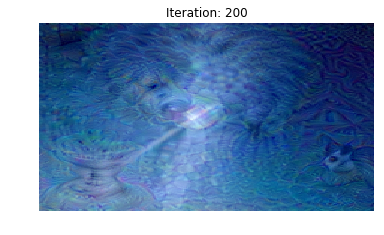

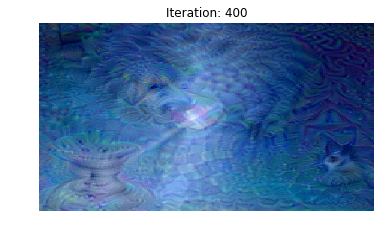

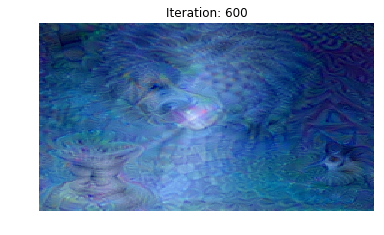

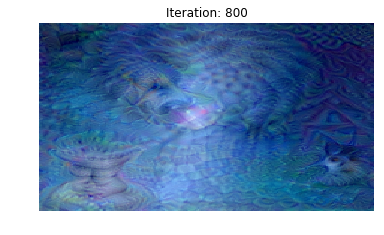

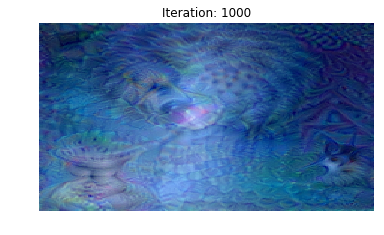

In [185]:
num_iterations = 1000
learning_rate = 10
max_jitter = 16                                                 # 最大抖动的像素值
show_every = 200
blur_every = 10
img = image_read(img_path).to(device).requires_grad_()          # 读入图像 顺序不能变，否则无梯度!!!

def deepdream(img, model, criterion, target=None):
    """
    img：需要进行deepdream的图像
    model：处理图像的模型
    criterion：优化的损失函数
    target：控制deepdream的图像特征
    """
    for i in range(num_iterations):
        # 1.对图像做抖动处理
        oh, ow = np.random.randint(-max_jitter, max_jitter + 1, 2)  # 随机选取抖动值    
        img.data.copy_(jitter(img.data.cpu(), oh, ow))              # 将图像抖动在赋值给自己 

        # 2.使用模型提取特征
        model.to(device)
        mynet.zero_grad()
        out = model(img)                                            # [1, 512, 7, 7]
        loss_out = criterion(out, target)
        out.backward(loss_out)                                      # 对应上述公式

        # 3.计算图像更新量并使用梯度上升法进行更新
        g = img.grad.data                                           # 读取输入图像的梯度
        dimg = learning_rate * g /  torch.norm(g, 2)                # torch.abs(g).mean()
        img.data.add_(dimg)
        img.grad.zero_()                               # mynet.zero_grad()，模型清零没有用

        # 4.定期对图像进行处理
        img.data.copy_(jitter(img.data.cpu(), -oh, -ow))            # 取消随机抖动还原图像
        for c in range(3):                                          # 对3个通道分别进行裁剪
            min_value = float(-MEAN[c] / STD[c])                    # 使数据在[0,1]之间
            max_value = float((1.0-MEAN[c]) / STD[c])
            img.data[:,c].clamp_(min=min_value, max=max_value)      # 对c通道进行裁剪

        if i % blur_every == 0:
            blur_image(img.data, sigma=0.5)

        # 5.定期显示处理的结果
        if i == 0 or (i+1) % show_every == 0 or i == num_iterations-1:
            plt.title('Iteration: %d'%(i+1))
            show_tensor(img.data.clone().cpu())
    return img
dream_img = deepdream(img, mynet, l2_loss)

In [186]:
# 控制生成的梦境
def control_loss(out_feature, target_feature):
    """
    out_feature：模型输出的特征
    target_feature：用于控制梦境的特征
    """
    x = out_feature.data.cpu()                    # 将数据放到cpu上处理
    y = target_feature.data.cpu()
    N,C,H,W = out_feature.shape
    x = x.reshape(N, C, -1)                       # 将H和W放到一维 (N,C,H*W)
    x = x.permute(0, 2, 1)                        # 交换维度 (N, H*W, C)
    y = y.reshape(N, C, -1)                       # (N, C, H'*W')
#     print(y.shape)
    A = torch.matmul(x, y)                        # (N, H*W, H'*W')  多维矩阵相乘，提取x与y的差异
    result = y[:,:,A.argmax(dim=2)[0]]
    result = result.reshape(N,C,H,W).to(device)   # 与out_feature同维度
#     print(result.shape)
    return result

In [187]:
# 提取目标图像的特征
target_img_path = os.path.join('./image/dog.jpg') # 
target_img_tensor = image_read(target_img_path)
target_img_tensor = target_img_tensor.to(device)
mynet.to(device)
target_feat = mynet(target_img_tensor)

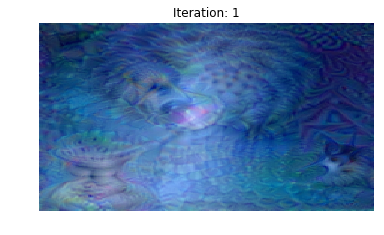

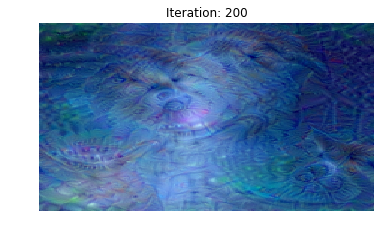

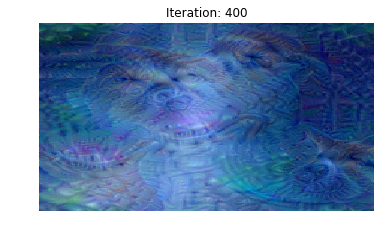

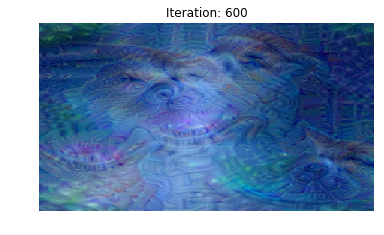

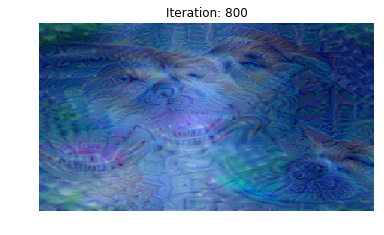

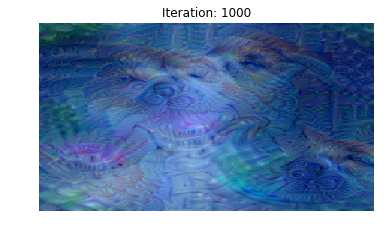

In [188]:
num_iterations = 1000
learning_rate = 10
max_jitter = 16                                                # 最大抖动的像素值
show_every = 200
blur_every = 10
dream_img = deepdream(img, mynet, control_loss, target_feat)

参考：[cs231n assignment3](https://github.com/2033329616/cs231n-2018/blob/master/assignment3/NetworkVisualization-PyTorch.ipynb)， [DeepDream](https://github.com/L1aoXingyu/code-of-learn-deep-learning-with-pytorch/blob/master/chapter9_Computer-Vision/Deep-Dream/deepdream.py)

1. `transforms.Resize((size,size))`会将宽和高都进行resize，transforms.Resize(size)只会处理一个边